In [11]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'PyECLAT'

In [ ]:
df = pd.read_csv('data/trabalho4_dados_4.csv')
df = df.astype(bool)
df

,ABSORVENTE,ACETONA,ACHOCOLATADO,ACUCAR,ADOCANTE,AGUA_OXIGENADA,AGUA,ALGODAO,AMENDOIN,AMONIA,...,TOALHA_DE_BANHO,TOALHA_DE_ROSTO,TORNEIRA,TORRADA,TRIGO_DE_QUIBE,UTEN_COZINHA,VELA_DE_FILTRO,VELA,VERDURAS,VINAGRE
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4780,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4781,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4782,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
itemsets = apriori(df, min_support=0.01, use_colnames=True)
itemsets

,support,itemsets
0,0.019440,(ABSORVENTE)
1,0.037625,(ACHOCOLATADO)
2,0.054557,(ACUCAR)
3,0.010242,(AMENDOIN)
4,0.010870,(APRESUNTADO)
...,...,...
1100,0.010452,"(LIMP_ROUPAS, FEIJAO, PROD_LIMPEZA, MACARRAO, ..."
1101,0.010661,"(OLEO_VEGETAL, LEGUMES, LIMP_ROUPAS, PROD_LIMP..."
1102,0.010661,"(LEGUMES, LIMP_ROUPAS, PROD_LIMPEZA, MACARRAO,..."
1103,0.010242,"(LEGUMES, LIMP_ROUPAS, FEIJAO, PROD_LIMPEZA, M..."


Mediana de suporte para itemsets: 0.011496655518394648
75% maiores suportes: 0.014005016722408026
90% maiores suportes: 0.020066889632107024
95% maiores suportes: 0.027550167224080258


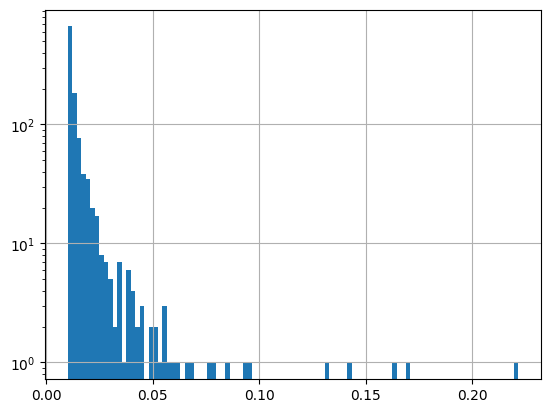

In [ ]:
print(f"Mediana de suporte para itemsets: {itemsets['support'].median()}")
print(f"75% maiores suportes: {itemsets['support'].quantile(0.75)}")
print(f"90% maiores suportes: {itemsets['support'].quantile(0.90)}")
print(f"95% maiores suportes: {itemsets['support'].quantile(0.95)}")
itemsets['support'].hist(bins=100)
plt.yscale('log')

In [ ]:
itemsets = apriori(df, min_support=0.02, use_colnames=True)
regras = association_rules(itemsets, len(df), metric="confidence", min_threshold=0.01)
regras.sort_values(by="lift", ascending=False)
regras  

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ACUCAR),(ARROZ),0.054557,0.039925,0.020485,0.375479,9.404666,1.0,0.018307,1.537298,0.945239,0.276836,0.349508,0.444284
1,(ARROZ),(ACUCAR),0.039925,0.054557,0.020485,0.513089,9.404666,1.0,0.018307,1.941717,0.930833,0.276836,0.484992,0.444284
2,(ACUCAR),(BISCOITO),0.054557,0.221781,0.022366,0.409962,1.848498,1.0,0.010267,1.318930,0.485508,0.088066,0.241809,0.255405
3,(BISCOITO),(ACUCAR),0.221781,0.054557,0.022366,0.100848,1.848498,1.0,0.010267,1.051483,0.589834,0.088066,0.048963,0.255405
4,(CAFE),(ACUCAR),0.059365,0.054557,0.024247,0.408451,7.486698,1.0,0.021009,1.598249,0.921111,0.270396,0.374315,0.426448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,"(LIMP_ROUPAS, PROD_LIMPEZA)",(LEGUMES),0.051212,0.163253,0.020276,0.395918,2.425190,1.0,0.011915,1.385156,0.619381,0.104413,0.278060,0.260059
130,"(LEGUMES, PROD_LIMPEZA)",(LIMP_ROUPAS),0.035535,0.079431,0.020276,0.570588,7.183406,1.0,0.017453,2.143790,0.892506,0.214128,0.533536,0.412926
131,(LIMP_ROUPAS),"(LEGUMES, PROD_LIMPEZA)",0.079431,0.035535,0.020276,0.255263,7.183406,1.0,0.017453,1.295041,0.935064,0.214128,0.227824,0.412926
132,(LEGUMES),"(LIMP_ROUPAS, PROD_LIMPEZA)",0.163253,0.051212,0.020276,0.124200,2.425190,1.0,0.011915,1.083338,0.702316,0.104413,0.076927,0.260059


Mediana de confiaça para regras: 0.26059392726059394
75% maiores confianças: 0.39739508479448116
90% maiores confianças: 0.4943396226415095
95% maiores confianças: 0.5502294425623651


<Axes: >

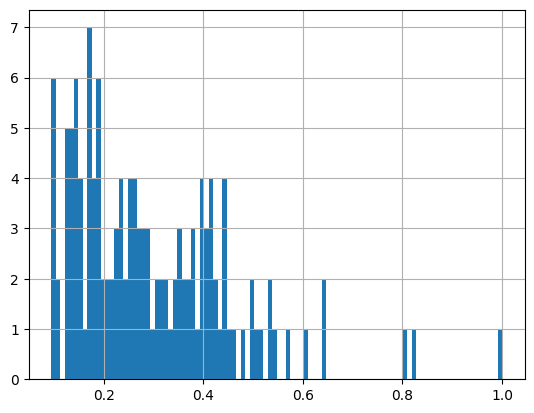

In [ ]:
print(f"Mediana de confiaça para regras: {regras['confidence'].median()}")
print(f"75% maiores confianças: {regras['confidence'].quantile(0.75)}")
print(f"90% maiores confianças: {regras['confidence'].quantile(0.90)}")
print(f"95% maiores confianças: {regras['confidence'].quantile(0.95)}")
regras['confidence'].hist(bins=100)
# plt.yscale('log')

In [8]:
itemsets = apriori(df, min_support=0.02, use_colnames=True)
regras = association_rules(itemsets, len(df), metric="confidence", min_threshold=0.5)
regras.sort_values(by="lift", ascending=False)
regras  

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ARROZ),(ACUCAR),0.039925,0.054557,0.020485,0.513089,9.404666,1.0,0.018307,1.941717,0.930833,0.276836,0.484992,0.444284
1,(ARROZ),(FEIJAO),0.039925,0.044314,0.021321,0.534031,12.050973,1.0,0.019552,2.050966,0.955153,0.338870,0.512425,0.507582
2,(ARROZ),(LEGUMES),0.039925,0.163253,0.021530,0.539267,3.303269,1.0,0.015012,1.816122,0.726266,0.118527,0.449376,0.335575
3,(CREME_DE_LEITE),(LEITE),0.035117,0.085075,0.035117,1.000000,11.754300,1.0,0.032129,inf,0.948224,0.412776,1.000000,0.706388
4,(EXTRATO_DE_TOMATE),(MACARRAO),0.033027,0.077341,0.020067,0.607595,7.856038,1.0,0.017513,2.351292,0.902517,0.222222,0.574702,0.433527
5,(FEIJAO),(LEGUMES),0.044314,0.163253,0.022157,0.500000,3.062740,1.0,0.014923,1.673495,0.704724,0.119504,0.402448,0.317862
6,(FEIJAO),(OLEO_VEGETAL),0.044314,0.061873,0.022157,0.500000,8.081081,1.0,0.019415,1.876254,0.916885,0.263682,0.467023,0.429054
7,(FEIJAO),(PROD_LIMPEZA),0.044314,0.142977,0.022575,0.509434,3.563059,1.0,0.016239,1.747009,0.752698,0.137056,0.427593,0.333664
8,(LIMP_ROUPAS),(PROD_LIMPEZA),0.079431,0.142977,0.051212,0.644737,4.509388,1.0,0.039856,2.412362,0.845391,0.299145,0.585469,0.501462
9,(MORTADELA),(PAES),0.034699,0.169314,0.022366,0.644578,3.806991,1.0,0.016491,2.337183,0.763829,0.123130,0.572135,0.388339


In [ ]:
def eclat(df, min_support):
    vertical_db = {item: set(df.index[df[item] == 1]) for item in df.columns}
    
    def recursive_eclat(prefix, items):
        results = []
        for i, (item, tids) in enumerate(items):
            new_prefix = prefix + [item]
            new_tids = tids
            support = len(new_tids)
            relative_support = support / len(df)

            if relative_support >= min_support:
                results.append((set(new_prefix), support, relative_support))
                new_items = [(other, other_tids & new_tids) for other, other_tids in items[i+1:] if len(other_tids & new_tids) >= min_support]
                results.extend(recursive_eclat(new_prefix, new_items))
        
        return results
    
    frequent_itemsets = recursive_eclat([], sorted(vertical_db.items(), key=lambda x: len(x[1]), reverse=True))
    
    return pd.DataFrame(frequent_itemsets, columns=["Itemset", "Support", "Relative Support"])


frequent_itemsets_df = eclat(df, min_support=0.01)

frequent_itemsets_df

,Itemset,Support,Relative Support
0,{BISCOITO},1061,0.221781
1,"{PAES, BISCOITO}",212,0.044314
2,"{PAES, LEGUMES, BISCOITO}",60,0.012542
3,"{PAES, PROD_LIMPEZA, BISCOITO}",54,0.011288
4,"{PAES, BISCOITO, SUCO}",64,0.013378
...,...,...,...
1100,{APRESUNTADO},52,0.010870
1101,{ODORIZANTE},52,0.010870
1102,{TORRADA},51,0.010661
1103,{AMENDOIN},49,0.010242


In [26]:
import numpy as np
from scipy.stats import chi2_contingency

# Exemplo de contagem de ocorrências
f_11 = 30   # A e B ocorrem juntos
f_10 = 70   # A ocorre sem B
f_01 = 50   # B ocorre sem A
f_00 = 850  # Nenhum dos dois ocorre

# Criar a matriz de contingência
table = np.array([[f_11, f_10], [f_01, f_00]])

# Aplicar o teste qui-quadrado
chi2, p_value, _, expected = chi2_contingency(table)

# Exibir resultados
print(f"Qui-Quadrado: {chi2:.4f}")
print(f"P-Valor: {p_value:.4f}")
print("Frequências esperadas:")
print(expected)

# Interpretação do resultado
if p_value < 0.05:
    print("A regra é estatisticamente significativa!")
else:
    print("A regra pode ter surgido ao acaso.")


Qui-Quadrado: 69.7841
P-Valor: 0.0000
Frequências esperadas:
[[  8.  92.]
 [ 72. 828.]]
A regra é estatisticamente significativa!
